In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\ncvn\\.cache\\kagglehub\\datasets\\wcukierski\\enron-email-dataset\\versions\\2\\emails.csv")

In [2]:
VECTOR_DB_NAME = "email_faiss_normalized_e5"

In [3]:

print(df.head())  
print(df.info()) 
print(df.columns) 

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None
Index(['file', 'message'], dtype='object')


In [4]:
df['file'][0]

'allen-p/_sent_mail/1.'

In [5]:
from pprint import pprint
pprint(df['message'][30000])

('Message-ID: <6440303.1075855883977.JavaMail.evans@thyme>\n'
 'Date: Sun, 10 Dec 2000 06:32:00 -0800 (PST)\n'
 'From: veronica.espinoza@enron.com\n'
 'To: debbie.brackett@enron.com, william.bradford@enron.com, \n'
 '\tandrew.conner@enron.com, genia.fitzgerald@enron.com, \n'
 '\tpatrick.hanse@enron.com, kelly.lovvorn@enron.com, \n'
 '\tmelissa.murphy@enron.com, kyle.schultz@enron.com, \n'
 '\tkim.theriot@enron.com, greg.wolfe@enron.com, \n'
 '\tchristian.yoder@enron.com, donald.black@enron.com, \n'
 '\twinston.cheng@enron.com, paul.choi@enron.com, \n'
 '\tdavid.fairley@enron.com, mike.miller@enron.com, \n'
 '\tpatrice.mims@enron.com, steve.neal@enron.com, \n'
 '\tkimberly.olinger@enron.com, charles.otto@enron.com, \n'
 '\tlee.papayoti@enron.com, david.parquet@enron.com, \n'
 '\tsusan.pereira@enron.com, beth.perlman@enron.com, \n'
 '\tbo.petersen@enron.com, sylvia.pollan@enron.com, \n'
 '\tbrent.price@enron.com, daniel.reck@enron.com, \n'
 '\tleslie.reeves@enron.com, brian.riley@enron.c

In [6]:
import random
str(df['message'][random.randint(0,5000)]).split()

['Message-ID:',
 '<23691808.1075857574917.JavaMail.evans@thyme>',
 'Date:',
 'Wed,',
 '27',
 'Sep',
 '2000',
 '11:44:00',
 '-0700',
 '(PDT)',
 'From:',
 'john.arnold@enron.com',
 'To:',
 'ina.rangel@enron.com',
 'Subject:',
 'Mime-Version:',
 '1.0',
 'Content-Type:',
 'text/plain;',
 'charset=us-ascii',
 'Content-Transfer-Encoding:',
 '7bit',
 'X-From:',
 'John',
 'Arnold',
 'X-To:',
 'Ina',
 'Rangel',
 'X-cc:',
 'X-bcc:',
 'X-Folder:',
 '\\John_Arnold_Dec2000\\Notes',
 'Folders\\All',
 'documents',
 'X-Origin:',
 'Arnold-J',
 'X-FileName:',
 'Jarnold.nsf',
 'Hi:',
 'Can',
 'you',
 'get',
 'me',
 'subscriptions',
 'to',
 'the',
 'following',
 'magazines:',
 'The',
 'Economist',
 'Energy',
 'Risk',
 'Management',
 'Havard',
 'Business',
 'Review',
 'Thanks,',
 'John']

In [7]:
import faiss
import numpy as np
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_experimental.text_splitter import SemanticChunker


# Use Microsoft E5 model instead of MPNet
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}  # Uses the cosine similarity
model = HuggingFaceEmbeddings(
    model_name="intfloat/e5-base-v2", #sentence-transformers/all-mpnet-base-v2
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)


C:\Users\ncvn\AppData\Local\Temp\ipykernel_7260\4187839505.py:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  model = HuggingFaceEmbeddings(
c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible.

In [8]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=350, chunk_overlap=50)

text_splitter = SemanticChunker(model)
email_texts = df["message"].iloc[:500].dropna().tolist()

In [9]:
len(email_texts)

500

In [10]:
import re

def clean_text(text: str) -> str:
    """
    Clean text while preserving useful characters:
    - Removes weird/unprintable symbols
    - Keeps letters, numbers, basic punctuation: @ . , ? : ; ! ( ) &
    - Normalizes whitespace
    """
    # Remove anything not in the allowed set
    text = re.sub(r"[^A-Za-z0-9@.,?;:!()&\ ]", '', text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()


In [11]:
from langchain_core.documents import Document
import pprint


docslist = []
for i, ec in enumerate(email_texts):
    
    split_msg = ec.split()
    msg_start = split_msg.index("X-FileName:")
    sender = split_msg[split_msg.index("From:")+1]
    recips = []
    try:
        for idx in range(split_msg.index("To:")+1, split_msg.index("Subject:")):
            recips.append(split_msg[idx])
    except:
        for idx in range(split_msg.index("X-To:")+1, split_msg.index("Subject:")):
            recips.append(split_msg[idx])

    subject_start_idx = split_msg.index("Subject:")+1
    subject_end_idx = split_msg.index("Mime-Version:")

    date_idx = split_msg.index("Date:")+1
    date_idx_end = date_idx + 6

    full_content = clean_text(" ".join(split_msg[msg_start+3:]))

    prefix = {"sender":sender,"recipient":" ".join(recips),"date":" ".join(split_msg[date_idx : date_idx_end]), 
              "subject":" ".join(split_msg[subject_start_idx:subject_end_idx])}
    
    final_list = text_splitter.split_text(full_content)
    for f in final_list:
        docslist.append(Document(metadata=prefix, page_content="passage: " + f))

In [12]:
import numpy as np

def l2_normalize(embeddings: np.ndarray) -> np.ndarray:
    """
    L2-normalizes an array.
    If the input is 1D, normalize the whole vector.
    If it's 2D, normalize each row.
    """
    if embeddings.ndim == 1:
        norm = np.linalg.norm(embeddings)
        return embeddings / norm if norm != 0 else embeddings
    else:
        norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
        norm[norm == 0] = 1  # avoid division by zero
        return embeddings / norm

# Extract text from Document objects
docs_texts = [doc.page_content for doc in docslist]  # Get only text content

# Generate embeddings for each text
embeddings = model.embed_documents(docs_texts)  # List[List[float]]

embeddings = l2_normalize(np.array(embeddings))  # Ensure it's NumPy and normalized



In [13]:
np.save("embeddings.npy",embeddings)
# Create (text, embedding) pairs for FAISS
text_embedding_pairs = list(zip(docs_texts, embeddings))  # Convert np.array to list

# Store in FAISS
db = FAISS.from_embeddings(text_embedding_pairs, model, metadatas=[doc.metadata for doc in docslist])
db.save_local(VECTOR_DB_NAME)

In [14]:
len(email_texts)

500

In [15]:
len(docslist)

880

In [16]:
# import asyncio
# import concurrent.futures
# from langchain_community.vectorstores import FAISS
# def process_batch_sync(db, batch_docs, batch_id):
#     loop = asyncio.new_event_loop()
#     asyncio.set_event_loop(loop)
#     loop.run_until_complete(db(batch_docs))
#     loop.close()
#     print(f"Batch {batch_id} added ({len(batch_docs)} docs).")

# async def batch_insert(db, docslist, batch_size=50, num_workers=6):
#     loop = asyncio.get_running_loop()
    
#     with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
#         tasks = []
        
#         for i in range(0, len(docslist), batch_size):
#             batch_docs = docslist[i : i + batch_size]
#             batch_id = i // batch_size
#             tasks.append(loop.run_in_executor(executor, process_batch_sync, db, batch_docs, batch_id))
        
#         await asyncio.gather(*tasks) 

# await batch_insert(db, docslist, batch_size=50)

In [17]:
db.save_local(VECTOR_DB_NAME)
print("FAISS index updated and saved")

FAISS index updated and saved


In [18]:
db = FAISS.load_local(VECTOR_DB_NAME,model,allow_dangerous_deserialization=True)

In [19]:
model

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='intfloat/e5-base-v2', cache_folder=None, model_kwargs={'device': 'cpu'}, encode_kwargs={'normalize_embeddings': False}, multi_process=False, show_progress=False)

In [34]:
from initialize_groq import init_groq
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
        """
            Answer question only provided the context. Give a detailed answer IN minimum 5 sentences!
            SAY I DONT KNOW IF CONTEXT IS NOT ENOUGH. DONT MAKE UP ANSWERS. BUT YOU ARE FREE TO INFER/SUGGEST.
            {context}

            Here is question:
            {input}
        """
)

retriever = db.as_retriever(search_kwargs={'k':20, 'search_type':'mmr','lambda_mult':0.2})

_, llm = init_groq(model_name="llama-3.3-70b-versatile")
import random
from initialize_groq import api_keys
llm.groq_api_key = random.choice(api_keys)
document_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, document_chain)

# Retrieve Top-K Similar Documents (Initial Broad Search)
retriever_topk = db.as_retriever(search_kwargs={'k': 20,'fetch_k' : 100, 'search_type': 'similarity'})  # Retrieve more docs first

# MMR for Diversity (Reduce Redundant Docs)
retriever_mmr = db.as_retriever(search_kwargs={'k': 20, 'fetch_k' : 100, 'search_type': 'mmr', 'lambda_mult': 0})  

# Create the Hybrid Retrieval Pipeline
retrieval_chain_topk = create_retrieval_chain(retriever_topk, document_chain)  # Initial broad search
retrieval_chain_mmr = create_retrieval_chain(retriever_mmr, document_chain)    # Apply MMR re-ranking
# retrieval_chain_threshold = create_retrieval_chain(retriever_threshold, document_chain)  # Final filtering

In [21]:
for d in docslist:
    print(d)

page_content='passage: Here is our forecast' metadata={'sender': 'phillip.allen@enron.com', 'recipient': 'tim.belden@enron.com', 'date': 'Mon, 14 May 2001 16:39:00 -0700', 'subject': ''}
page_content='passage: Traveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary. As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn.' metadata={'sender': 'phillip.allen@enron.com', 'recipient': 'john.lavorato@enron.com', 'date': 'Fri, 4 May 2001 13:51:00 -0700', 'subject': 'Re:'}
page_content='passage: The meetings might be better if held in a 

In [35]:
import pprint
query = "give me emails related to salary"
pprint.pprint(retrieval_chain_topk.invoke({"input":query}))
llm.groq_api_key = random.choice(api_keys)
pprint.pprint(retrieval_chain_mmr.invoke({"input":query}))

{'answer': 'Based on the provided context, I can identify a few emails related '
           'to salary. \n'
           '\n'
           'One email is from Phillip to an unspecified recipient, where he '
           "discusses the recipient's salary, stating that $260/week plus the "
           'apartment is all he can pay at the moment. He also mentions that '
           "he had increased the recipient's pay last year to help them make "
           'ends meet and believes the current wages equate to $10/hour, which '
           'he thinks is fair. \n'
           '\n'
           'Another email is from an unspecified sender to Phillip, where they '
           'ask him to send a schedule of the salary and level of everyone in '
           'the scheduling group, along with any thoughts on changes that need '
           'to be made.\n'
           '\n'
           'There is also an email where Phillip instructs the recipient to '
           'implement certain changes, including daily timesheets

In [40]:
from langchain_community.vectorstores.faiss import FAISS
import numpy as np
test_questions = [
    "What does randy need to send a schedule of?",
    "What are some of randy's action items?",
    "What is Philip's proposal focused on, and can you provided details about the proposal?",
    "Can you provide me more detail about the microturbine power generation deal?"
]
for text in test_questions:
    # Define query
    query = "query: " + text
    pprint.pprint(retrieval_chain_topk.invoke({"input":query}))
    # Generate and normalize query embedding
    query_embedding = np.array(model.embed_query(query))
    query_embedding = l2_normalize(query_embedding)  # Ensure it's normalized
    llm.groq_api_key = random.choice(api_keys)
    # Perform similarity search (returns L2 distance)
    # topk_results = db.similarity_search_with_score_by_vector(
    #     embedding=query_embedding.tolist(),  # List[float]
    #     k=20
    # )

    # # Sort by L2 distance (ascending: lower = more similar)
    # topk_sorted = sorted(topk_results, key=lambda x: x[1])

    # # Display results with L2 distance and cosine similarity
    # for doc, l2_score in topk_sorted:
    #     # Convert L2 distance to cosine similarity (assuming L2-normalized)
    #     cosine_sim = 1 - (l2_score ** 2) / 2
    #     print(f"Document: {doc.page_content[:100]} {str(doc.metadata)[:10]} | L2 Distance: {l2_score:.4f} | Cosine Sim: {cosine_sim:.4f}")


{'answer': 'Based on the provided context, it appears that Randy is not '
           'directly mentioned in relation to sending a schedule. However, '
           'there is a mention of an "amortization schedule" in one of the '
           'passages, and it is Phillip who mentions that he will find and '
           'send this schedule. \n'
           '\n'
           'It can be inferred that Randy might be involved in a discussion or '
           'meeting where a schedule needs to be sent, but the context does '
           'not provide enough information to confirm this. The passage that '
           'mentions the amortization schedule is related to a conversation '
           'between Phillip and someone else, where Phillip agrees to find and '
           'send the schedule. \n'
           '\n'
           'Without more context or information, it is difficult to determine '
           'what Randy needs to send a schedule of. The provided passages seem '
           'to be a collection of 

In [42]:
from langchain_community.vectorstores.faiss import FAISS
import numpy as np
test_questions = [
    "What does randy need to send a schedule of?",
    "What are some of randy's action items?",
    "What is Philip's proposal focused on, and can you provided details about the proposal?",
    "Can you provide me more detail about the microturbine power generation deal?"
]
for text in test_questions:
    print("=========================================================")
    # Define query
    query = "query: " + text
    # pprint.pprint(retrieval_chain_topk.invoke({"input":query}))
    # Generate and normalize query embedding
    query_embedding = np.array(model.embed_query(query))
    query_embedding = l2_normalize(query_embedding)  # Ensure it's normalized
    # llm.groq_api_key = random.choice(api_keys)
    # Perform similarity search (returns L2 distance)
    topk_results = db.similarity_search_with_score_by_vector(
        embedding=query_embedding.tolist(),  # List[float]
        k=20
    )

    # Sort by L2 distance (ascending: lower = more similar)
    topk_sorted = sorted(topk_results, key=lambda x: x[1])

    # Display results with L2 distance and cosine similarity
    for doc, l2_score in topk_sorted:
        # Convert L2 distance to cosine similarity (assuming L2-normalized)
        cosine_sim = 1 - (l2_score ** 2) / 2
        print(f"Document: {doc.page_content[:100]} | L2 Distance: {l2_score:.4f} | Cosine Sim: {cosine_sim:.4f}")


Document: passage: get with randy to resolve. | L2 Distance: 0.3754 | Cosine Sim: 0.9295
Document: passage: Please let me know if this time fits in your schedules. Thanks, Larry | L2 Distance: 0.4212 | Cosine Sim: 0.9113
Document: passage: Forwarded by Phillip K AllenHOUECT on 07112000 04:59 PM From: Robert Badeer 07112000 02:44  | L2 Distance: 0.4343 | Cosine Sim: 0.9057
Document: passage: Forwarded by Phillip K AllenHOUECT on 02092001 09:26 AM Jeff Smith jsmith@austintx.com on 0 | L2 Distance: 0.4374 | Cosine Sim: 0.9043
Document: passage: Allan. PS: Colleen is setting up a meeting tomorrow to discuss the direction for transport. | L2 Distance: 0.4391 | Cosine Sim: 0.9036
Document: passage: Allan. PS: Colleen is setting up a meeting tomorrow to discuss the direction for transport. | L2 Distance: 0.4391 | Cosine Sim: 0.9036
Document: passage: Updated curves will be sent no later than 11 am on Monday 27. I want Keith to be involved i | L2 Distance: 0.4391 | Cosine Sim: 0.9036
Document:

In [24]:
# for doc in docslist:
#     print(len(doc.page_content.split()))
    

In [25]:
from langchain_core.tools import tool

# Ensure retrieval_chain is correctly defined before calling this tool
@tool
def ragtool(query: str) -> str:
    """
    This is a retrieval-augmented generation (RAG) tool that queries a vector store 
    containing Enron emails.
    
    Parameters:
    query (str): The input query for retrieval.
    
    Returns:
    str: The retrieved answer from the vector store.
    """
    try:
        answer = retrieval_chain_mmr.invoke({"input": query})['answer']
        return f"Here is the ANSWER. \n ```{answer}```\n DO NOT USE THE TOOL REPEATEDLY. SHOW THE ANSWER TO THE USER. \n"
    except Exception as e:
        return f"Error: Failed to retrieve answer. Details: {str(e)}"


In [26]:
from typing import Literal
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.memory import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.prebuilt import ToolNode, tools_condition



toolnode = ToolNode([ragtool])

def call_model(state: MessagesState):
    state["messages"]
    messages = state["messages"]
    #print(messages)
    llm.groq_api_key = random.choice(api_keys)
    llm_with_tool = llm.bind_tools([ragtool])
    response = llm_with_tool.invoke(messages)
    
    
    return {"messages": [response]}

from langgraph.graph import END
def router_function(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

memory = MemorySaver()
workflow = StateGraph(MessagesState)    
workflow.add_node("agent", call_model)
workflow.add_node(toolnode)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router_function,
    {
       "tools": "tools",
       END: END,
    },
)
workflow.add_edge("tools", "agent")
app = workflow.compile(checkpointer=memory)



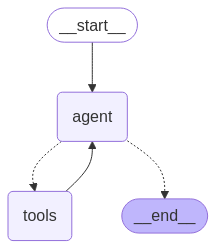

In [27]:
from IPython.display import display_png
display_png(app.get_graph().draw_mermaid_png(),raw=True)

In [28]:
import time
while True:
    theinput = input("Enter something: ")
    if 'exit' in theinput:
        break
    inp = {"messages":[theinput]}
    
    config = {"configurable": {"thread_id": 1}}
    events = app.stream(inp, config=config, stream_mode="values")

    for event in events:
        event["messages"][-1].pretty_print()
    time.sleep(1)

In [29]:
# from typing import Literal, List
# from langchain_core.runnables.history import RunnableWithMessageHistory
# from langgraph.graph import StateGraph, START, END, MessagesState
# from langgraph.checkpoint.memory import MemorySaver
# from langchain.memory import ChatMessageHistory
# from langchain_core.chat_history import BaseChatMessageHistory, InMemoryChatMessageHistory
# from langgraph.prebuilt import ToolNode
# from langchain_core.documents import Document
# from langchain_core.tools import tool
# from langchain.chat_models import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate

# # === Define Custom Tools ===


# @tool
# def filter_emails_by_keyword(emails: List[Document], keywords: List[str]) -> List[Document]:
#     """Filter emails that contain the given keywords in the content or metadata."""
#     def filter_email(email):
#         content = email.page_content.lower()
#         metadata = " ".join(str(val).lower() for val in email.metadata.values())
#         return any(keyword.lower() in content or keyword.lower() in metadata for keyword in keywords)
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(lambda e: e if filter_email(e) else None, emails)))

#     return filtered_emails

# @tool
# def filter_emails_by_metadata(
#     emails: List[Document], sender: str = None, recipient: str = None, date: str = None
# ) -> List[Document]:
#     """Filter emails by metadata fields like sender, recipient, or date."""
#     def filter_email(email):
#         if sender and email.metadata.get("sender", "").lower() != sender.lower():
#             return None
#         if recipient and recipient.lower() not in email.metadata.get("recipient", "").lower():
#             return None
#         if date and date not in email.metadata.get("date", ""):
#             return None
#         return email
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(filter_email, emails)))
    
#     return filtered_emails

# @tool
# def summarize_emails(emails: List[Document]) -> List[Document]:
#     """Summarize emails before adding them to FAISS."""
#     _,llm = init_groq(model_name="llama-3.3-70b-versatile")
#     prompt = ChatPromptTemplate.from_template("Summarize the following email:\n{email}")
#     summarized_docs = []
#     for email in emails:
#         chain = prompt | llm
#         summary = chain.invoke(email.page_content)
#         summarized_docs.append(Document(page_content=summary.content, metadata=email.metadata))
#     return summarized_docs

# toolnode = ToolNode([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])
# llm_with_tool = llm.bind_tools([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])

# # === Define Model Function ===
# def call_model(state: MessagesState):
#     """Modify agent behavior to apply filtering and summarization before RAG."""
#     messages = state["messages"]
#     query = messages[-1]

#     # Step 1: Apply Keyword Filtering
#     filtered_emails = filter_emails_by_keyword.invoke({"emails": docslist, "keywords": [query.content]})

#     # Step 2: Apply Metadata Filtering
#     filtered_emails = filter_emails_by_metadata.invoke(
#         {"emails": filtered_emails, "sender": "", "recipient": "", "date": ""}
#     )

#     # Step 3: Summarize Emails if Needed
#     summarized_emails = summarize_emails.invoke({"emails": filtered_emails})

#     # Step 4: Run RAG Tool on Filtered Emails
#     state["messages"].append("\n")
#     response = llm_with_tool.invoke([summarized_emails])

#     return {"messages": [response]}

# # === Define Router Function ===
# def router_function(state: MessagesState) -> Literal["tools", END]:
#     messages = state["messages"]
#     last_message = messages[-1]
#     if last_message.tool_calls:
#         return "tools"
#     return END

# # === Build LangGraph Workflow ===
# memory = MemorySaver()
# workflow = StateGraph(MessagesState)
# workflow.add_node("agent", call_model)
# workflow.add_node(toolnode)
# workflow.add_edge(START, "agent")
# workflow.add_conditional_edges(
#     "agent",
#     router_function,
#     {
#         "tools": "tools",
#         END: END,
#     },
# )
# workflow.add_edge("tools", "agent")
# app = workflow.compile(checkpointer=memory)

# while True:
#     theinput = input("Enter something: ")
#     if 'exit' in theinput:
#         break
#     inp = {"messages":[theinput]}

#     config = {"configurable": {"thread_id": 1}}
#     events = app.stream(inp, config=config, stream_mode="values")

#     for event in events:
#         event["messages"][-1].pretty_print()
